In [1]:
import geopandas as gpd

file_path = "/Users/Administrator/Downloads/California_Fire_Perimeters_(all).geojson"

gdf = gpd.read_file(file_path)

print(gdf.info())
gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22261 entries, 0 to 22260
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   OBJECTID       22261 non-null  int32              
 1   YEAR_          22184 non-null  float64            
 2   STATE          22261 non-null  object             
 3   AGENCY         22208 non-null  object             
 4   UNIT_ID        22197 non-null  object             
 5   FIRE_NAME      22199 non-null  object             
 6   INC_NUM        21566 non-null  object             
 7   ALARM_DATE     16865 non-null  datetime64[ms, UTC]
 8   CONT_DATE      9632 non-null   datetime64[ms, UTC]
 9   CAUSE          22237 non-null  float64            
 10  C_METHOD       10140 non-null  float64            
 11  OBJECTIVE      22014 non-null  float64            
 12  GIS_ACRES      22261 non-null  float64            
 13  COMMENTS       20034 non-null  object 

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,...,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,Shape__Area,Shape__Length,geometry
0,1,2023.0,CA,CDF,SKU,WHITWORTH,00004808,2023-06-17 00:00:00+00:00,2023-06-17 00:00:00+00:00,5.0,...,5.729125,None,None,{7985848C-0AC2-4BA4-8F0E-29F778652E61},None,None,2020.0,41407.839844,1247.166034,"POLYGON ((-122.91148 41.53201, -122.9115 41.53..."
1,2,2023.0,CA,LRA,BTU,KAISER,00010225,2023-06-02 00:00:00+00:00,2023-06-02 00:00:00+00:00,5.0,...,13.602380,None,None,{43EBCC88-B3AC-48EB-8EF5-417FE0939CCF},None,None,2020.0,93455.878906,1285.514550,"POLYGON ((-121.96182 39.8297, -121.96181 39.82..."
2,3,2023.0,CA,CDF,AEU,JACKSON,00017640,2023-07-01 00:00:00+00:00,2023-07-02 00:00:00+00:00,2.0,...,27.814460,None,None,{B64E1355-BF1D-441A-95D0-BC1FBB93483B},None,None,2020.0,183028.500000,2697.587429,"POLYGON ((-120.90644 38.29537, -120.90397 38.2..."
3,4,2023.0,CA,CDF,AEU,CARBON,00018821,2023-07-11 00:00:00+00:00,2023-07-11 00:00:00+00:00,9.0,...,58.760230,None,None,{CB41DB0A-E4B1-489D-A4EA-738F2CD6DB3B},None,None,2020.0,388221.953125,2548.738779,"POLYGON ((-120.98579 38.44344, -120.98488 38.4..."
4,5,2023.0,CA,CDF,AEU,LIBERTY,00018876,2023-07-11 00:00:00+00:00,2023-07-12 00:00:00+00:00,14.0,...,70.979000,None,None,{F83F70A4-07A7-40B8-BD51-10CCC1C30D63},None,None,2020.0,466456.007812,5106.936526,"POLYGON ((-120.98886 38.25035, -120.98895 38.2..."


In [3]:
# Select relevant columns
selected_columns = ["geometry", "GIS_ACRES", "YEAR_", "STATE", "FIRE_NAME"]
df = gdf[selected_columns].dropna()

# Convert year to numerical format
df["YEAR_"] = df["YEAR_"].astype(int)

# Convert to a projected CRS (e.g., UTM Zone 10N for California)
gdf = gdf.to_crs(epsg=32610)  # EPSG 32610 is UTM for California

# Extract centroid coordinates (latitude, longitude)
df["latitude"] = gdf.geometry.centroid.y
df["longitude"] = gdf.geometry.centroid.x


# Drop geometry column (not needed for ML)
df.drop(columns=["geometry"], inplace=True)

# Display processed data
df.head()


,GIS_ACRES,YEAR_,STATE,FIRE_NAME,latitude,longitude
0,5.729125,2023,CA,WHITWORTH,4.597840e+06,507332.705479
1,13.602380,2023,CA,KAISER,4.409486e+06,588749.611240
2,27.814460,2023,CA,JACKSON,4.240635e+06,683231.132125
3,58.760230,2023,CA,CARBON,4.256779e+06,675923.915761
4,70.979000,2023,CA,LIBERTY,4.235145e+06,675366.931024


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features (X) and target (y)
X = df[["GIS_ACRES", "YEAR_", "latitude", "longitude"]]
y = (df["GIS_ACRES"] > 1000).astype(int)  # 1 = Large Fire, 0 = Small Fire

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Model Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3613
           1       1.00      1.00      1.00       812

    accuracy                           1.00      4425
   macro avg       1.00      1.00      1.00      4425
weighted avg       1.00      1.00      1.00      4425



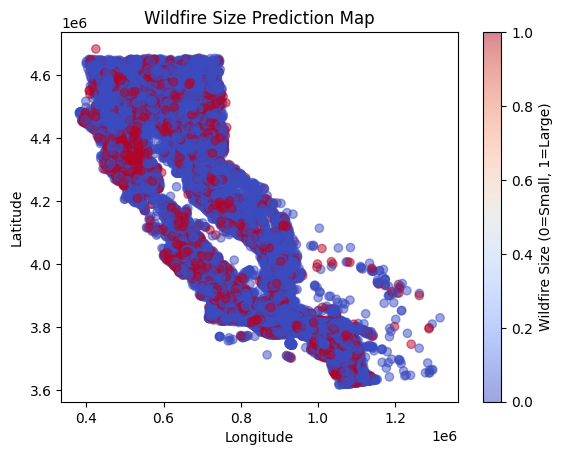

In [6]:
import matplotlib.pyplot as plt

# Scatter plot of predictions
plt.scatter(df["longitude"], df["latitude"], c=y, cmap="coolwarm", alpha=0.5)
plt.colorbar(label="Wildfire Size (0=Small, 1=Large)")
plt.title("Wildfire Size Prediction Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [11]:
import folium
import geopandas as gpd
import pandas as pd
from folium.plugins import HeatMap

# Load the dataset (already processed)
file_path = "/Users/Administrator/Downloads/California_Fire_Perimeters_(all).geojson"
gdf = gpd.read_file(file_path)

# Ensure data has latitude and longitude columns
gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (if not already)
gdf["latitude"] = gdf.geometry.centroid.y
gdf["longitude"] = gdf.geometry.centroid.x

# Convert to a Pandas DataFrame
df = gdf[["latitude", "longitude", "GIS_ACRES"]].dropna()

# Create a Folium Map centered on California
m = folium.Map(location=[37.5, -119.5], zoom_start=6, tiles="OpenStreetMap")

# Create a HeatMap layer using wildfire locations and intensity based on size (GIS_ACRES)
heat_data = list(zip(df.latitude, df.longitude, df.GIS_ACRES))
HeatMap(heat_data, min_opacity=0.3, max_zoom=9, radius=15, blur=10).add_to(m)

# Save and display the map
m.save("wildfire_heatmap.html")
m


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15084\1252075316.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["latitude"] = gdf.geometry.centroid.y
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15084\1252075316.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["longitude"] = gdf.geometry.centroid.x
